In [1]:
import torch
import torchvision  
import torch.nn.functional as F  

from torch import optim 
from torch import nn  
from torch.utils.data import DataLoader 

from tqdm import tqdm 
import numpy as np
import utils
import nn_model

import config
from torchsummary import summary

C:\Users\mati\anaconda3\envs\pytorch_2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
batch_size = 64
input_size = 28*28
lstm_hidden_size = 64
learning_rate = 0.001
num_epochs = 1
num_lstm_layers = 2

## Load data

In [4]:
custom_train_loader = utils.MnistSequences(weak_supervision_rate = 0.1)
custom_test_loader = utils.MnistSequences(train=False)

In [5]:
custom_train_loader.reset()
custom_test_loader.reset()

train_loader = DataLoader(dataset=custom_train_loader, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=custom_test_loader, batch_size=config.BATCH_SIZE, shuffle=True)

## Visualize data

In [6]:
(x, y) = next(iter(train_loader))

columns = len(x[0])
rows = 1
fig = plt.figure(figsize=(10, 10))

for idx in range(1*columns):
    
    image = x[0][idx]
    fig.add_subplot(rows, columns, idx+1)
    plt.imshow(image)
    
print("label:", y[0])

NameError: name 'plt' is not defined

## Model

In [7]:
model = nn_model.LSTM_Model(
    config.INPUT_SIZE, 
    config.LSTM_HIDDEN_SIZE, 
    config.NUM_LSTM_LAYERS, 
    device
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [8]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            73,856
├─LSTM: 1-6                              82,944
├─Linear: 1-7                            130
Total params: 180,226
Trainable params: 180,226
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            73,856
├─LSTM: 1-6                              82,944
├─Linear: 1-7                            130
Total params: 180,226
Trainable params: 180,226
Non-trainable params: 0

In [14]:
history_1 = []
for epoch in range(config.NUM_EPOCHS):
    for batch_idx, (x_data, y_data) in enumerate(tqdm(train_loader)):

        x_data = x_data.to(device=device).squeeze(1)
        y_data = y_data.to(device=device)

        # forward
        outputs = model(x_data)
        loss = criterion(outputs, y_data)

        # backward
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 50 == 0:
            validation_acc = utils.validate(test_loader, model, 20, device)
            train_acc = utils.validate(train_loader, model, 20, device)
            history_1.append((validation_acc,train_acc))
            print("Val acc:",validation_acc, "Train acc:", train_acc)
            checkpoint = f"checkpoints//batch_idx{batch_idx}.pt"
            torch.save(model, checkpoint)
            model.train()
        


  0%|                                                                                | 1/938 [00:08<2:09:37,  8.30s/it]

Val acc: 0.9703124761581421 Train acc: 0.89453125


  5%|████▍                                                                            | 51/938 [00:31<38:50,  2.63s/it]

Val acc: 0.983593761920929 Train acc: 0.8921874761581421


 11%|████████▌                                                                       | 100/938 [00:53<07:26,  1.88it/s]

Val acc: 0.981249988079071 Train acc: 0.9046875238418579


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints//batch_idx100.pt'

In [13]:
checkpoint = f"checkpoints//batch_idx{batch_idx}.pt"
torch.save(model, checkpoint)

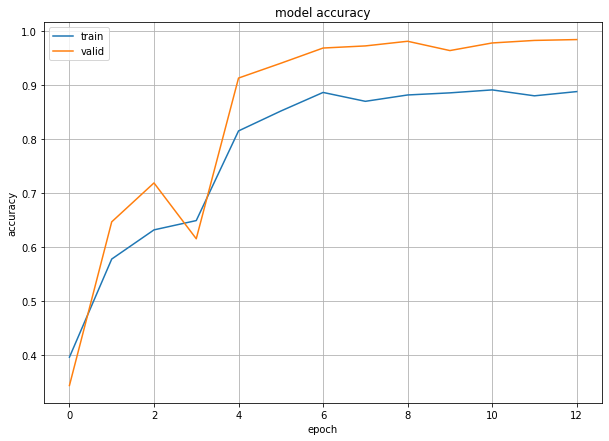

In [11]:
utils.save_fig(history_1, "foo2.png")

## Test

In [ ]:
def check_accuracy(data_loader, model):
    
    N = 0
    num_correct = 0
    
    # Set model to evaluate state
    model.eval()

    with torch.no_grad():
        for x_data, y_data in data_loader:
            
            x_data = x_data.to(device=device).squeeze(1)
            y_data = y_data.to(device=device)

            predictions = model(x_data)
            _, predictions = predictions.max(1)
            num_correct += (predictions == y_data).sum()
            N += predictions.size(0)

            print("Accuracy", 100. * num_correct / N)


check_accuracy(test_loader, model)

In [30]:

counter = 0
sequ = None
for x, y in test_loader:
    
    sequ = x
    print("L", y)
    
    counter +=1
    if counter >= 1: break

seq_len = len(sequ[0])
print("seq_len:", seq_len)

L tensor([0.9000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.1000, 0.9000, 0.1000,
        0.1000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.9000, 0.1000, 0.9000,
        0.1000, 0.9000, 0.9000, 0.1000, 0.9000, 0.1000, 0.1000, 0.9000, 0.1000,
        0.9000, 0.9000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.1000, 0.9000, 0.9000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.1000, 0.9000, 0.1000, 0.9000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.1000, 0.9000,
        0.9000], dtype=torch.float64)
seq_len: 8


In [32]:
predicted = model(sequ.to(device=device).squeeze(1))
_, predicted = predicted.max(1)
predicted

tensor([0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052], grad_fn=<ViewBackward0>)